In [ ]:
import numpy as np
import zarr
import cupy as cp

In [ ]:
from dask import array as da
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

In [ ]:
cluster = LocalCUDACluster()
client = Client(cluster)
client

2023-01-16 17:44:03,833 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-01-16 17:44:03,834 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-01-16 17:44:03,843 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-01-16 17:44:03,843 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-01-16 17:44:03,849 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-01-16 17:44:03,849 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-01-16 17:44:03,888 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-01-16 17:44:03,888 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-01-16 17:44:03,917 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-01-16 17:44:03,917 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37018,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:34025,Total threads: 1
Dashboard: http://127.0.0.1:47049/status,Memory: 25.00 GiB
Nanny: tcp://127.0.0.1:42535,


In this tutorial, we introduce how to move data among disk, CPU memory and GPU memory with `Dask`.

We will futher use `Dask` for distributed computing.

## Read data

In [ ]:
cpu_coh = da.from_zarr('../../../data/emperical_coherence.zarr',chunks=(1000,1000,17,17))

In [ ]:
cpu_coh

dask.array<from-zarr, shape=(2500, 1834, 17, 17), dtype=complex64, chunksize=(1000, 1000, 17, 17), chunktype=numpy.ndarray>

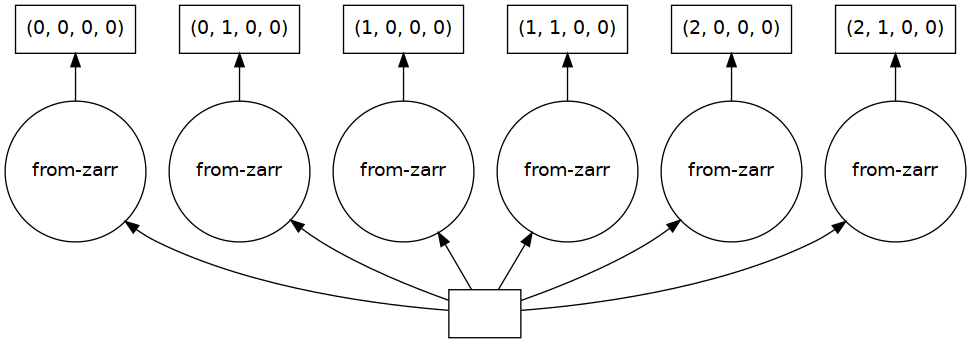

In [ ]:
cpu_coh.visualize()

## Convert data from CPU to GPU and convert back

In [ ]:
gpu_coh = da.map_blocks(cp.asarray,cpu_coh)
cpu_coh = da.map_blocks(cp.asnumpy,gpu_coh)
cpu_coh

dask.array<asnumpy, shape=(2500, 1834, 17, 17), dtype=complex64, chunksize=(1000, 1000, 17, 17), chunktype=numpy.ndarray>

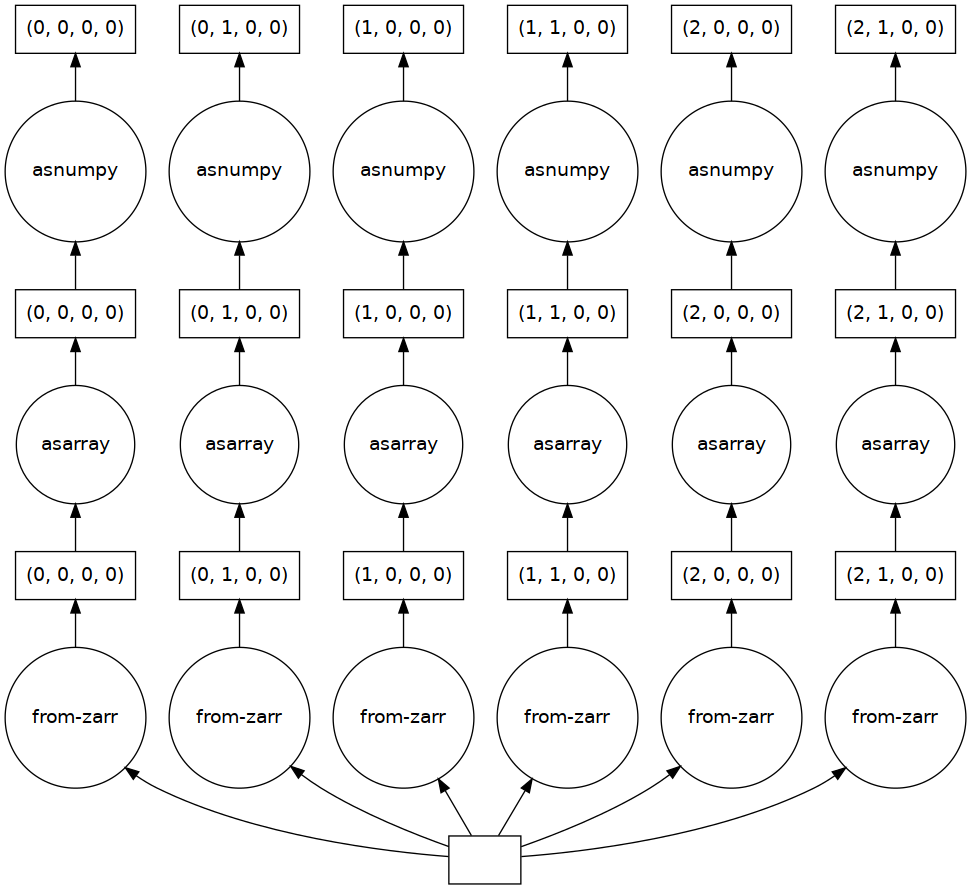

In [ ]:
cpu_coh.visualize()

## Save data

`dask.array.to_zarr` doesn't support write data with chunk size bigger than 2 G, so we rechunk it first:

In [ ]:
cpu_coh = cpu_coh.rechunk((500,500,17,17))
cpu_coh

dask.array<rechunk-merge, shape=(2500, 1834, 17, 17), dtype=complex64, chunksize=(500, 500, 17, 17), chunktype=numpy.ndarray>

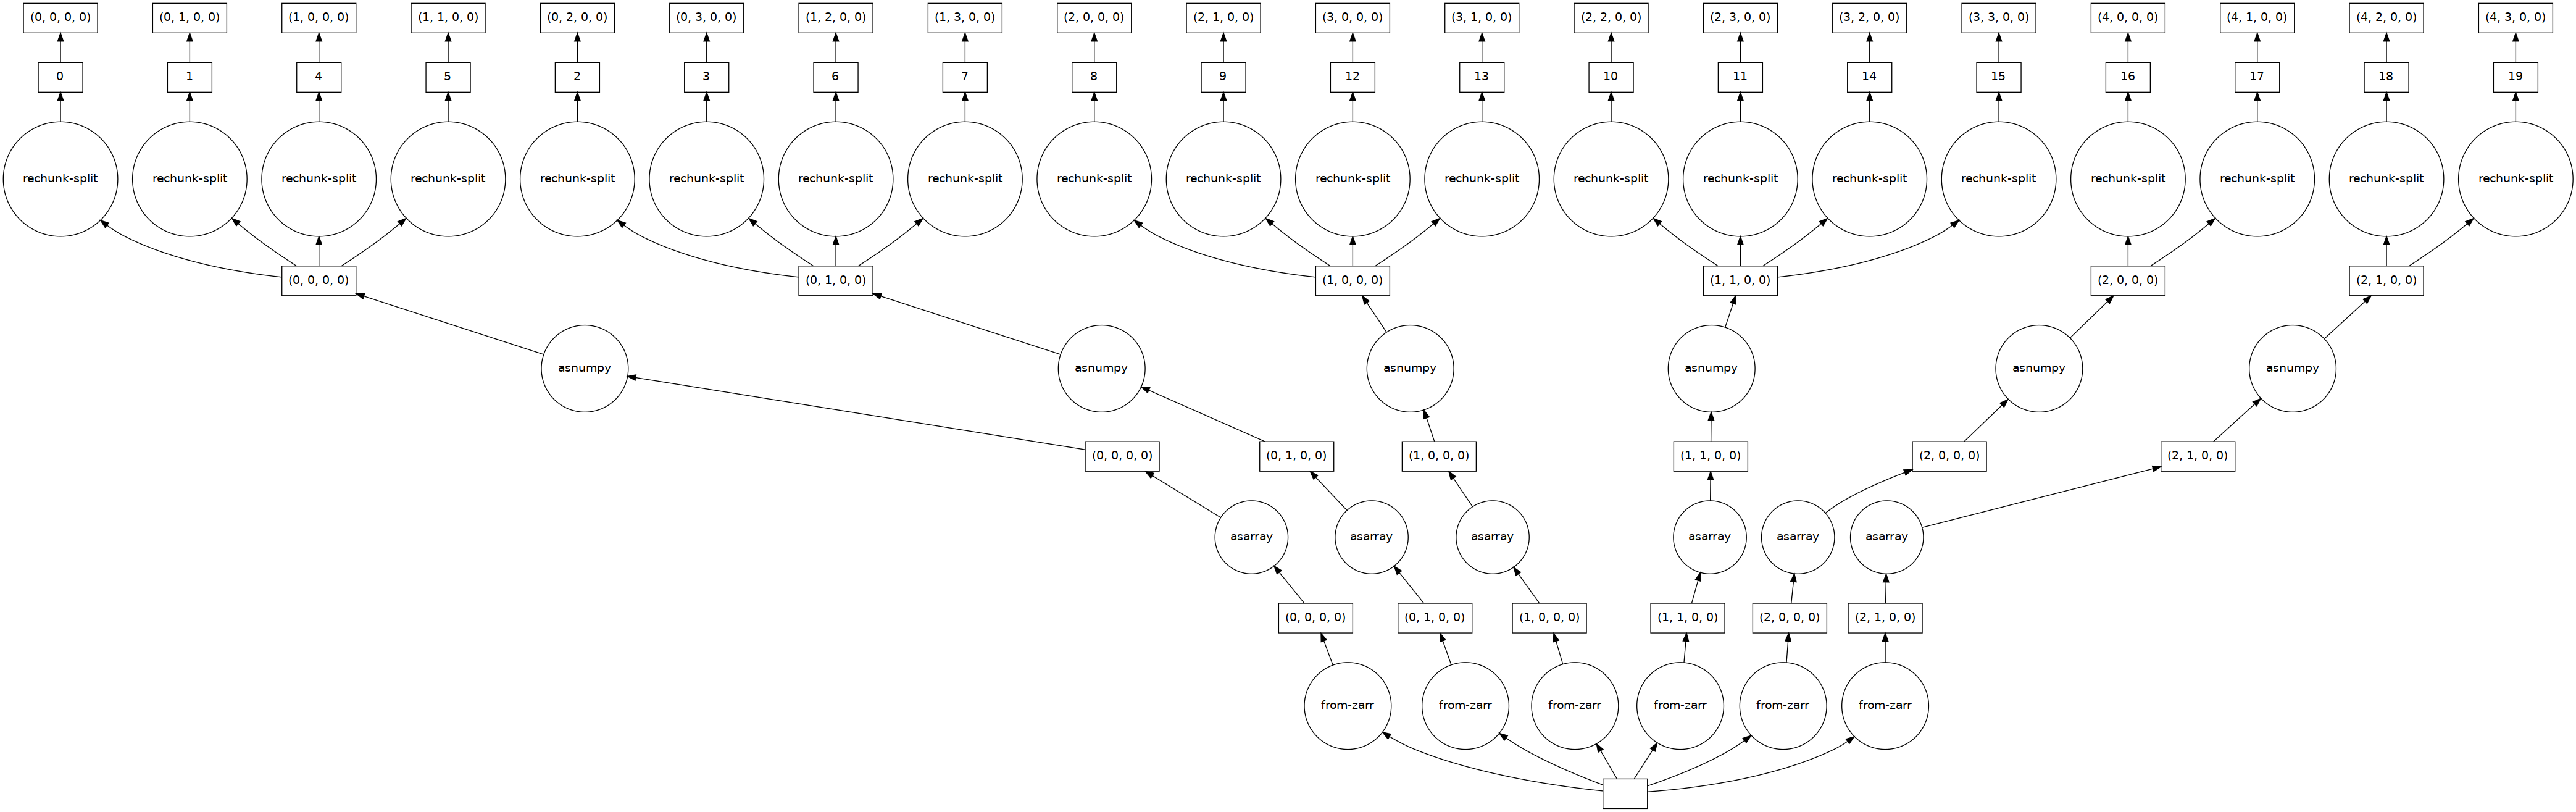

In [ ]:
cpu_coh.visualize()

In [ ]:
%%time
cpu_coh.to_zarr('../../../data/trash.zarr',overwrite=True)

CPU times: user 997 ms, sys: 2.2 s, total: 3.2 s
Wall time: 19.4 s


## Tips

Prevent call `compute()` directly. This will merge the worker memory together which consumes too much time:

In [ ]:
%%time
cpu_coh_result = cpu_coh.compute()

CPU times: user 11.3 s, sys: 16.4 s, total: 27.7 s
Wall time: 37.6 s


Using `persist()` instead when necessary:

In [ ]:
%%time
cpu_coh.persist()

CPU times: user 8 ms, sys: 9 ms, total: 17 ms
Wall time: 16.2 ms


dask.array<rechunk-merge, shape=(2500, 1834, 17, 17), dtype=complex64, chunksize=(500, 500, 17, 17), chunktype=numpy.ndarray>

In [ ]:
client.close()